<a href="https://colab.research.google.com/github/nullvoid-ky/introduction-to-machine-learning-and-deep-learning/blob/main/last/03_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install kagglehub numpy pandas seaborn matplotlib scikit-learn imbalanced-learn "ray[tune]"
# Import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

In [2]:
# @title DT
class DecisionNode:
  def __init__(self, impurity=None, feature_index=None, threshold=None, left=None, right=None):
    self.left = left
    self.right = right
    # The largest impurity value of this node
    self.impurity = impurity
    # Index of the feature which make the best fit for this node.
    self.feature_index = feature_index
    # The threshold value for that feature to make the split.
    self.threshold = threshold

class LeafNode:
  def __init__(self, value):
    self.prediction_value = value

class DecisionTreeClassifierFromScratch(BaseEstimator, ClassifierMixin):
  def __init__(self, min_sample_split=3, min_impurity=1e-7, max_depth=10, criterion='gini'):
    self.root = None
    self.min_sample_split = min_sample_split
    self.min_impurity = min_impurity
    self.max_depth = max_depth
    self.impurity_function = self._calculate_information_gain
    if criterion == 'entropy':
      self.criterion = self._entropy
      self.criterion_name = criterion
    else:
      self.criterion = self._gini_index
      self.criterion_name = 'gini'

  def _gini_index(self, y):
    gini = 1
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      gini += -np.square(p)
    return gini

  def _entropy(self, y):
    entropy = 0
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      entropy += -p * np.log2(p)
    return entropy

  def _calculate_information_gain(self, y, y1, y2):
    # :param y: target value.
    # :param y1: target value for dataset in the true split/right branch.
    # :param y2: target value for dataset in the false split/left branch.

    # propobility of true values.
    p = len(y1) / len(y)
    info_gain = self.criterion(y) - p * self.criterion(y1) - (1 - p) * self.criterion(y2)
    return info_gain

  def _leaf_value_calculation(self, y):
    most_frequent_label = None
    max_count = 0
    unique_labels = np.unique(y)
    # iterate over all the unique values and find their frequentcy count.
    for label in unique_labels:
      count = len( y[y == label])
      if count > max_count:
        most_frequent_label = label
        max_count = count
    return most_frequent_label

  def _partition_dataset(self, Xy, feature_index, threshold):
    col = Xy[:, feature_index]
    X_1 = Xy[col >= threshold]
    X_2 = Xy[col < threshold]

    return X_1, X_2

  def _find_best_split(self, Xy):
    best_question = tuple()
    best_datasplit = {}
    largest_impurity = 0
    n_features = (Xy.shape[1] - 1)
    # iterate over all the features.
    for feature_index in range(n_features):
      # find the unique values in that feature.
      unique_value = set(s for s in Xy[:,feature_index])
      # iterate over all the unique values to find the impurity.
      for threshold in unique_value:
        # split the dataset based on the feature value.
        true_xy, false_xy = self._partition_dataset(Xy, feature_index, threshold)

        # skip the node which has any on type 0. because this means it is already pure.
        if len(true_xy) > 0 and len(false_xy) > 0:
          # find the y values.
          y = Xy[:, -1]
          true_y = true_xy[:, -1]
          false_y = false_xy[:, -1]
          # calculate the impurity function.
          impurity = self.impurity_function(y, true_y, false_y)

          # if the calculated impurity is larger than save this value for comaparison (highest gain).
          if impurity > largest_impurity:
            largest_impurity = impurity
            best_question = (feature_index, threshold)
            best_datasplit = {
              "leftX": true_xy[:, :n_features],   # X of left subtree
              "lefty": true_xy[:, n_features:],   # y of left subtree
              "rightX": false_xy[:, :n_features],  # X of right subtree
              "righty": false_xy[:, n_features:]   # y of right subtree
            }

    return largest_impurity, best_question, best_datasplit

  def _build_tree(self, X, y, current_depth=0):
    n_samples , n_features = X.shape
    # Add y as last column of X
    Xy = np.column_stack((X, y))
    # find the Information gain on each feature each values and return the question which splits the data very well
    if (n_samples >= self.min_sample_split) and (current_depth < self.max_depth):
      # find the best split/ which question split the data well.
      impurity, question, best_datasplit = self._find_best_split(Xy)
      if impurity > self.min_impurity:
        # Build subtrees for the right and left branch.
        true_branch = self._build_tree(best_datasplit["leftX"], best_datasplit["lefty"], current_depth + 1)
        false_branch = self._build_tree(best_datasplit["rightX"], best_datasplit["righty"], current_depth + 1)
        return DecisionNode(impurity=impurity, feature_index=question[0], threshold=question[1],
                            left=true_branch, right=false_branch)

    leaf_value = self._leaf_value_calculation(y)
    return LeafNode(value=leaf_value)

  def fit(self, X, y):
    self.root = self._build_tree(X, y, current_depth=0)

  def predict_sample(self, x, tree=None):
    if isinstance(tree , LeafNode):
      return tree.prediction_value

    if tree is None:
      tree = self.root
    feature_value = x[tree.feature_index]
    branch = tree.right

    if isinstance(feature_value, int) or isinstance(feature_value, float):
      if feature_value >= tree.threshold:
        branch = tree.left
    elif feature_value == tree.threshold:
      branch = tree.left

    return self.predict_sample(x, branch)

  def predict(self, test_X):
    x = np.array(test_X)
    y_pred = [self.predict_sample(sample) for sample in x]
    y_pred = np.array(y_pred)
    return y_pred

  def draw_tree(self):
    self._draw_tree(self.root)

  def _draw_tree(self, tree = None, indentation = " ", depth=0):
    if isinstance(tree , LeafNode):
      print(indentation,"The predicted value -->", tree.prediction_value)
      return
    else:
      print(indentation,f"({depth}) Is {tree.feature_index}>={tree.threshold}?"
            f": {self.criterion_name}:{tree.impurity:.2f}")
      if tree.left is not None:
          print (indentation + '----- True branch :)')
          self._draw_tree(tree.left, indentation + "  ", depth+1)
      if tree.right is not None:
          print (indentation + '----- False branch :)')
          self._draw_tree(tree.right, indentation + "  ", depth+1)

  def predict_proba(self, X):
    X = np.array(X)
    probs = []
    for sample in X:
        node = self.root
        while not isinstance(node, LeafNode):
            feature_value = sample[node.feature_index]
            if feature_value >= node.threshold:
                node = node.left
            else:
                node = node.right
        # compute class probability in this leaf node
        y_leaf = node.prediction_value
        # If you only stored a single class, just make it binary
        if y_leaf == 1:
            probs.append(1.0)
        else:
            probs.append(0.0)
    return np.array(probs)

In [3]:
# @title RF
class RandomForestClassifierFromScratch:
    def __init__(
        self,
        max_feature=None,
        n_trees=100,
        min_sample_split=2,
        min_impurity=1e-7,
        max_depth=10,
        criterion="gini",
    ):
        # Initialize the trees.
        self.trees = []
        for _ in range(n_trees):
            self.trees.append(
                DecisionTreeClassifierFromScratch(
                    min_sample_split=min_sample_split,
                    min_impurity=min_impurity,
                    max_depth=max_depth,
                    criterion=criterion,
                )
            )

        self.tree_feature_indexes = []
        # Number of trees/estimetors.
        self.n_estimators = n_trees
        # How many features can be used for a tree from the whole features.
        self.max_features = max_feature
        # Aggication function to find the prediction.
        self.prediction_aggrigation_calculation = self._maximum_vote_calculation

    def _maximum_vote_calculation(self, y_preds):
        # Find which prediction class has higest frequency in all tree prediction for each sample.
        # create a empty array to store the prediction.
        y_pred = np.empty((y_preds.shape[0], 1))
        # iterate over all the data samples.
        for i, sample_predictions in enumerate(y_preds):
            y_pred[i] = np.bincount(sample_predictions.astype("int")).argmax()

        return y_pred

    def _make_random_subset(self, X, y, n_subsets, replacement=True):
        # Create a random subset of dataset with/without replacement.
        subset = []
        # use 100% of data when replacement is true , use 50% otherwise.
        sample_size = X.shape[0] if replacement else (X.shape[0] // 2)

        # Add y as last column of X
        Xy = np.column_stack((X, y))
        np.random.shuffle(Xy)
        # Select randome subset of data with replacement.
        for i in range(n_subsets):
            index = np.random.choice(
                range(sample_size),
                size=np.shape(range(sample_size)),
                replace=replacement,
            )
            X = Xy[index][:, :-1]
            y = Xy[index][:, -1]
            subset.append({"X": X, "y": y})
        return subset

    def fit(self, X, y):
        # if the max_features is not given then select it as square root of no on feature availabe.
        n_features = X.shape[1]
        if self.max_features == None:
            self.max_features = int(round(np.sqrt(n_features)))

        # Split the dataset into number of subsets equal to n_estimators.
        subsets = self._make_random_subset(X, y, self.n_estimators)

        for i, subset in enumerate(subsets):
            X_subset, y_subset = subset["X"], subset["y"]
            # select a random sucset of features for each tree. This is called feature bagging.
            idx = np.random.choice(
                range(n_features), size=self.max_features, replace=True
            )
            # track this for prediction.
            self.tree_feature_indexes.append(idx)
            # Get the X with the selected features only.
            X_subset = X_subset[:, idx]

            # change the y_subet to i dimentional array.
            y_subset = np.expand_dims(y_subset, axis=1)
            # build the model with selected features and selected random subset from dataset.
            self.trees[i].fit(X_subset, y_subset)

    def predict(self, test_X):
        y_preds = np.empty((test_X.shape[0], self.n_estimators))
        # find the prediction from each tree for each samples
        for i, tree in enumerate(self.trees):
            features_index = self.tree_feature_indexes[i]

            # test_X = (slice(None, None, None), array([8, 6, 0]))

            X_selected_features = test_X[:, features_index]
            if isinstance(tree, DecisionTreeClassifierFromScratch):
                y_preds[:, i] = tree.predict(X_selected_features).reshape((-1,))
            else:
                y_preds[:, i] = tree.predict(X_selected_features)
        # find the aggregated output.
        y_pred = self.prediction_aggrigation_calculation(y_preds)

        return y_pred

    def predict_proba(self, test_X):
        """
        Return probability of class 1 for each sample
        """
        y_preds = np.empty((test_X.shape[0], self.n_estimators))

        for i, tree in enumerate(self.trees):
            features_index = self.tree_feature_indexes[i]
            X_selected_features = test_X[:, features_index]
            y_preds[:, i] = tree.predict(X_selected_features).reshape((-1,))

        # probability for class 1 = fraction of trees predicting 1
        prob_class_1 = np.mean(y_preds == 1, axis=1)
        return prob_class_1

In [6]:
import kagglehub
path = kagglehub.dataset_download("utkarshx27/american-companies-bankruptcy-prediction-dataset")

print("Path to dataset files:", path)

file_path = "/kaggle/input/american-companies-bankruptcy-prediction-dataset/american_bankruptcy.csv"
df = pd.read_csv(file_path)
df.head()

Using Colab cache for faster access to the 'american-companies-bankruptcy-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/american-companies-bankruptcy-prediction-dataset


,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [7]:
df_unique = df.groupby("company_name", group_keys=False).apply(lambda x: x.sample(n=1))


/tmp/ipython-input-2508231616.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_unique = df.groupby("company_name", group_keys=False).apply(lambda x: x.sample(n=1))


In [8]:
df

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78677,C_8971,alive,2014,233.211,43.338,14.094,45.615,3.376,25.261,22.846,...,104.223,1099.101,184.666,31.521,60.885,28.197,28.095,104.223,225.887,58.608
78678,C_8971,alive,2015,105.559,59.184,42.592,202.133,2.288,129.688,54.611,...,291.153,1865.926,770.103,159.541,231.969,88.128,157.783,291.153,880.327,89.020
78679,C_8971,alive,2016,63.971,69.074,65.057,79.051,2.581,-1.442,42.467,...,169.858,1746.235,683.985,13.994,100.784,85.765,156.341,169.858,770.233,90.807
78680,C_8971,alive,2017,135.207,66.527,65.330,69.171,2.013,-20.401,27.217,...,161.884,1736.110,694.035,3.841,95.357,82.010,135.941,161.884,776.697,92.713


In [9]:
df_unique

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
17,C_1,alive,2016,888.500,1422.700,71.000,148.200,601.100,56.500,251.400,...,1767.600,1504.100,155.300,77.200,344.900,335.100,688.000,1767.600,589.900,1619.400
121,C_10,alive,2010,931.930,2125.206,414.555,1138.439,202.989,350.053,419.518,...,3263.645,12362.703,3045.794,723.884,1138.439,1310.736,1264.194,3263.645,8587.477,2125.206
1212,C_100,alive,2013,87.342,62.127,33.174,65.532,5.295,18.496,25.753,...,149.023,375.254,5.000,32.358,86.896,37.227,305.803,149.023,59.796,83.491
11936,C_1000,alive,2009,2936.396,2386.007,165.484,1439.706,301.229,730.502,969.662,...,5951.782,6475.250,1197.791,1274.222,3565.775,2451.954,6179.596,5951.782,4546.073,4512.076
11964,C_1001,alive,2017,37136.000,196858.000,806.000,3911.000,16310.000,67.000,17711.000,...,208357.000,60381.000,6751.000,3105.000,11499.000,36685.000,11268.000,208357.000,48865.000,204446.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11856,C_995,alive,1999,1021.516,2924.860,147.393,722.886,404.120,328.528,494.747,...,4323.673,2636.487,337.764,575.493,1398.813,853.023,1007.326,4323.673,1839.319,3600.787
11863,C_996,alive,1999,91.467,112.583,3.280,11.787,63.282,4.182,26.040,...,140.605,129.924,62.648,8.507,28.022,32.778,26.019,140.605,99.033,128.818
11866,C_997,alive,1999,490.600,1231.300,57.400,253.300,234.200,103.300,213.900,...,2006.900,1188.800,241.400,195.900,775.600,470.600,208.600,2006.900,806.400,1753.600
11896,C_998,failed,2009,2357.921,4913.017,157.419,653.700,502.325,387.056,716.836,...,6193.077,4849.110,56.714,496.281,1280.060,2009.032,338.650,6193.077,3016.010,5539.377


In [10]:
X = df_unique[
    ["X8", "X17", "X3", "X11", "X15", "X1", "X6"]
]
y = df_unique["status_label"].map({"alive": 0, "failed": 1})

In [11]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42
)


In [12]:

alive_count = (y_train == 0).sum()
failed_count = (y_train == 1).sum()

print(f"Alive: {alive_count}\nBankruptcy: {failed_count}")

Alive: 5448
Bankruptcy: 383


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [14]:

sm = SMOTE(random_state=42, k_neighbors=3)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [15]:

alive_count = (y_train == 0).sum()
failed_count = (y_train == 1).sum()

print(f"Alive: {alive_count}\nBankruptcy: {failed_count}")

Alive: 5448
Bankruptcy: 5448


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Grid Search
# Define hyperparameter grid for Random Forest
params = {
    "n_estimators": [100, 200],          # number of trees
    "max_depth": [8, 20, 40],           # limit tree depth
    "criterion": ["gini", "entropy"],         # impurity measure
}

# Define the Decision Tree model
model = RandomForestClassifier()

grid_dt = GridSearchCV(model, params, cv=6, scoring="f1")
grid_dt.fit(X_train, y_train)
print("Best parameters:", grid_dt.best_params_)
print("Best score:", grid_dt.best_score_)

# this took like 3 minutes
# Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
# Best score: 0.7857868020304568

Best parameters: {'criterion': 'gini', 'max_depth': 40, 'n_estimators': 200}
Best score: 0.9365746183282745


In [38]:
criterion = "gini"
max_depth= 10
n_estimators = 40

In [43]:
rf = RandomForestClassifierFromScratch(
    n_trees=5,
    max_depth=4,
    min_sample_split=4,
    min_impurity=1e-7,
    criterion='gini',
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test.to_numpy())


In [44]:
from sklearn.metrics import accuracy_score, f1_score
score = accuracy_score(y_test, y_pred)
print("Accuracy:", score)
score = f1_score(y_test, y_pred)
print("F1_score:", score)

Accuracy: 0.6337579617834395
F1_score: 0.18091168091168092


In [50]:


print(classification_report(rf.predict(X_test.to_numpy()), y_test))

              precision    recall  f1-score   support

         0.0       0.43      0.95      0.59      1323
         1.0       0.72      0.09      0.16      1817

    accuracy                           0.45      3140
   macro avg       0.58      0.52      0.38      3140
weighted avg       0.60      0.45      0.34      3140



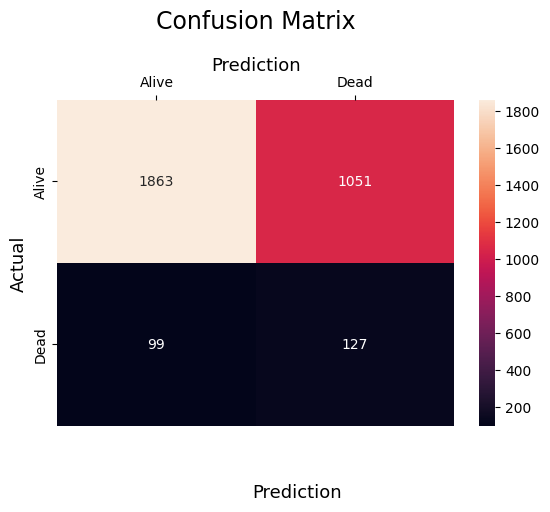

In [53]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    xticklabels=["Alive", "Dead"],
    yticklabels=["Alive", "Dead"],
)
plt.ylabel("Actual", fontsize=13)
plt.title("Confusion Matrix", fontsize=17, pad=20)
plt.gca().xaxis.set_label_position("top")
plt.xlabel("Prediction", fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, "Prediction", ha="center", fontsize=13)
plt.show()

AUC: 0.5986


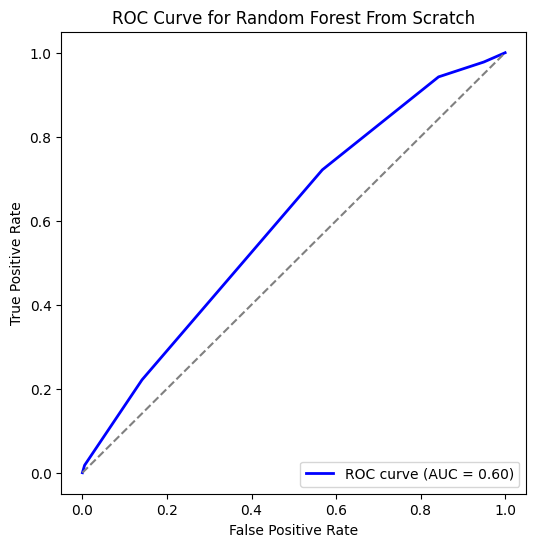

In [54]:
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_proba = rf.predict_proba(X_test.to_numpy())

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_pred_proba)

# Compute AUC
auc_score = roc_auc_score(y_test.to_numpy(), y_pred_proba)
print(f"AUC: {auc_score:.4f}")

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest From Scratch')
plt.legend(loc="lower right")
plt.show()

In [55]:
from sklearn.ensemble import RandomForestClassifier

Model_RF = RandomForestClassifier()
predict(Model_RF)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2914
           1       0.12      0.12      0.12       226

    accuracy                           0.87      3140
   macro avg       0.53      0.53      0.53      3140
weighted avg       0.87      0.87      0.87      3140



In [57]:
y_t_pred = Model_RF.predict(X_test)
accuracy_score(y_test, y_t_pred)

0.8707006369426752

In [58]:

f1_score(y_test, y_t_pred)

0.12121212121212122

In [59]:
confusion_matrix(y_test, y_t_pred)

array([[2706,  208],
       [ 198,   28]])